# Generate the Fit Configuration

This block generates the config file for the statistical fit.  Note that this block contains everything that we are allowed to modify in order to change the results of the fit!

In [1]:
%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"
import json
import pathlib
import copy

# ===============================================================================================================
# Change these if we need to change the sample we're running on.
#
SIGNAL_SAMPLE_PREFIX = "VBFSUSY"
center_of_mass="13"
mass="150"
mixing="Higgsino"
# ===============================================================================================================

# ===============================================================================================================
# Define selections.

# Preselection requirements, mostly about jets.
# To-do's:
# -- add mindphi(MET,jets)>0.4,<2.8 requirement
# -- require VBF jets to have pT>60
# -- optimize dEta requirement
pre_selection="( abs(j1Eta - j2Eta) > 3.0 )"

# Distinction between signal regions and control regions, mostly about leptons.
# To-do's:
# -- Extend this to include electrons
sig_selection="(nMuon == 0)"
CRW_selection="(nMuon == 1)"
CRZ_selection="(nMuon == 2)"
# ===============================================================================================================

# ===============================================================================================================
# Define Jet Regions
# To-do's:
# -- Test different setups, binning out to more than 3 or 4 jets, more inclusive regions for better stats, etc
jet_selections = {
    "lownJets": "(njet == 2)",
    "mednJets": "(njet == 3)",
#    "hignJets": "(njet >= 4)",
}

# Define MET regions
# To-do's:
# -- find optimal upper MET requirement, and then define medium/low MET categories from there
met_selections = {
    "medMET": "(MET >= 200) & (MET < 300)",
    "higMET": "(MET >=300)",
}

# Define mjj bins.
# To-do's:
# -- Find optimal binning.
variable = "MET"
#binning = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
binning = [200,400,600,800,1000,1200,1400,1600,1800]
# ===============================================================================================================



# ===============================================================================================================
# 
# Most things below here won't need to change, at least for VBFSUSY setups.
#
sig_path = pathlib.Path(f"/data/users/mhance/SUSY/{SIGNAL_SAMPLE_PREFIX}_{center_of_mass}_{mixing}_{mass}_mjj_all.root")

base_config = {
    "General": {
        "Measurement": "main",
        "POI": "mu",
        "HistogramFolder": "histograms/",
        "InputPath": "{SamplePaths}",
    },
    "Regions": [],
    "Samples": [],
    "Systematics": [],
    "NormFactors": [],
}

# Construct all the regions: CR's, VR's, SR's
for jet_name, jet_selection in jet_selections.items():
    for met_name, met_selection in met_selections.items():
        base_config["Regions"].append(
            {
                "Name": f"SR_{met_name}_{jet_name}",
                "Filter": f"{pre_selection} & {sig_selection} & {jet_selection} & {met_selection}",
                "Variable": variable,
                "Binning": binning,
            }
        )

        base_config["Regions"].append(
            {
                "Name": f"CRW_{met_name}_{jet_name}",
                "Filter": f"{pre_selection} & {CRW_selection} & {jet_selection} & {met_selection}",
                "Variable": variable,
                "Binning": binning,
            }
        )

        base_config["Regions"].append(
            {
                "Name": f"CRZ_{met_name}_{jet_name}",
                "Filter": f"{pre_selection} & {CRZ_selection} & {jet_selection} & {met_selection.replace('MET','MET_invismu')}",
                "Variable": variable,
                "Binning": binning,
            }
        )

config = copy.deepcopy(base_config)

# Define Samples
config["Samples"].append(
    {
        "Name": sig_path.name.replace(".root", "").split("/")[-1],
        "Tree": "presel/hftree",
        "SamplePaths": str(sig_path.resolve()),
        "Weight": "weight",
        "Data": False,
    }
)
bkgpaths=[]
for path in pathlib.Path("/data/users/mhance/SUSY").glob(f"Vjj*_{center_of_mass}*.root"):
    config["Samples"].append(
        {
            "Name": path.name.replace(".root", "").split("/")[-1],
            "Tree": "presel/hftree",
            "SamplePaths": str(path.resolve()),
            "Weight": "weight",
            "Data": False,
        }
    )
    bkgpaths+=[str(path.resolve())]

# Add a "Data" Sample (use background to set limits, use background+signal for significance)
config["Samples"].append(
    {
        "Name": "data",
        "Tree": "presel/hftree",
        "SamplePaths": bkgpaths,
        "Weight": "weight",
        "Data": True,
    }
)

# Define Systematics.  For now these are just flat systematics.
# Should eventually define a shape systematic too.
config["Systematics"].append(
    {
        "Name": "flat_uncertainty",
        "Up": {"Normalization": 0.3},
        "Down": {"Normalization": -0.3},
        "Samples": [sample["Name"] for sample in config["Samples"]],
        "Type": "Normalization",
    },
)

config["NormFactors"].append(
    {
        "Name": "mu",
        "Samples": sig_path.name.replace(".root", "").split("/")[-1],
        "Nominal": 1,
        "Bounds": [0, 10],
    }
)

# write out the config JSON file.
cabinetry_config_yaml=sig_path.name.replace(".root", ".yml")
pathlib.Path(cabinetry_config_yaml).write_text(
    json.dumps(config, indent=4, sort_keys=True)
)
# ===============================================================================================================

7218

In [27]:
import csv, sys
import uproot
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy import array
import subprocess

np.set_printoptions(threshold=sys.maxsize)
import shap
import tensorflow as tf
import tkinter as tk
import matplotlib
import matplotlib.pyplot as plt
import os

# don't use these in notebook mode
#from matplotlib.backends.backend_pdf import PdfPages
#matplotlib.use("PDF")
import math
import time
from math import log, sqrt
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Normalized data to range from (0,1)
from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from datetime import datetime

In [84]:

x = [1,2,3,4,5,6,7,8,9,10]
yet = np.array([1,0,1,0,1,0,1,0,1,0])
np.where((yet==0)|(yet==1), yet^1, yet)

X = ma.masked_array(x, mask=np.where((yet==0)|(yet==1), yet^1, yet))
Z = numpy.ma.MaskedArray.compressed(X)
print(len(X))
print(X)

10
[1 -- 3 -- 5 -- 7 -- 9 --]


In [81]:
x = np.array([1,2,3,4,5,6,7,8,9,10])
y = np.array([0,0,0,0,0,0])
X = x[len(y):]
Y = x[:len(y)]
len(X)+len(Y)
len(X)


4

[array([3., 1., 0., 2., 0., 3., 0., 0., 2., 5.])
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ])
 <BarContainer object of 10 artists>]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


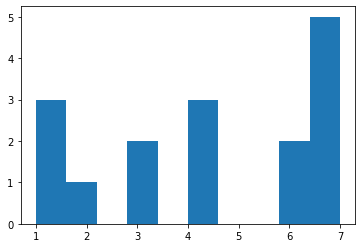

In [73]:
x = [1,1,1,3,2,3,4,4,4,7,7,7,7,7,6,6]
n = plt.hist(x)
n= np.array(n)
print(n)

# Run the Fit 

Now run the fit.  Remove the ";" at the end of lines to see the output.

In [2]:
import cabinetry
cabinetry_config = cabinetry.configuration.load(cabinetry_config_yaml);

In [3]:
# create template histograms
cabinetry.template_builder.create_histograms(cabinetry_config);

SR_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [0 1 2 3 4 5 6 7]
CRW_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [0 1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_higMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal ha

In [4]:
# perform histogram post-processing
cabinetry.template_postprocessor.run(cabinetry_config);

SR_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [0 1 2 3 4 5 6 7]
CRW_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRW_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal has empty bins: [0 1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VjjEWK_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_VjjQCD_13_mjj_all_Nominal has empty bins: [1 2 3 4 5 6 7]
CRZ_medMET_lownJets_data_Nominal has empty bins: [1 2 3 4 5 6 7]
SR_higMET_lownJets_VBFSUSY_13_Higgsino_150_mjj_all_Nominal ha

/opt/tljh/user/lib/python3.7/site-packages/cabinetry/contrib/matplotlib_visualize.py:119: RuntimeWarning: invalid value encountered in true_divide
  rel_mc_unc = total_model_unc / total_yield
/opt/tljh/user/lib/python3.7/site-packages/cabinetry/contrib/matplotlib_visualize.py:132: RuntimeWarning: invalid value encountered in true_divide
  data_model_ratio = data_histogram_yields / total_yield
/opt/tljh/user/lib/python3.7/site-packages/cabinetry/contrib/matplotlib_visualize.py:133: RuntimeWarning: invalid value encountered in true_divide
  data_model_ratio_unc = data_histogram_stdev / total_yield
/opt/tljh/user/lib/python3.7/site-packages/cabinetry/contrib/matplotlib_visualize.py:119: RuntimeWarning: invalid value encountered in true_divide
  rel_mc_unc = total_model_unc / total_yield
/opt/tljh/user/lib/python3.7/site-packages/cabinetry/contrib/matplotlib_visualize.py:132: RuntimeWarning: invalid value encountered in true_divide
  data_model_ratio = data_histogram_yields / total_yield
/

figures/CRW_higMET_mednJets_prefit_log.pdf
figures/SR_higMET_mednJets_prefit_log.pdf
figures/CRW_higMET_lownJets_prefit_log.pdf
figures/CRZ_higMET_lownJets_prefit_log.pdf
figures/CRZ_higMET_mednJets_prefit_log.pdf
figures/SR_higMET_lownJets_prefit_log.pdf


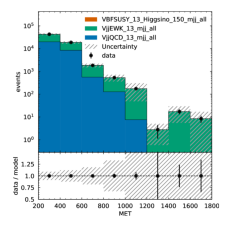

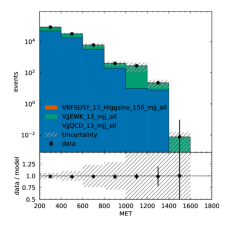

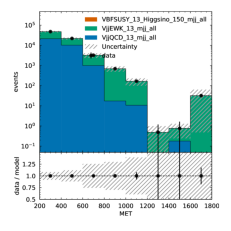

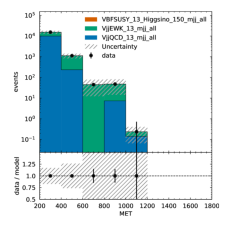

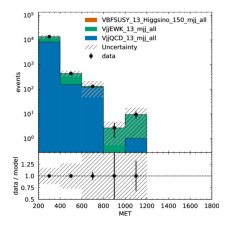

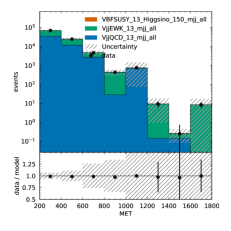

In [5]:
# visualize templates and data
import os
import shutil
shutil.rmtree("figures")
os.mkdir("figures")
cabinetry.visualize.data_MC_from_histograms(cabinetry_config, "figures/")
import glob
import matplotlib.pyplot as plt
import wand
from wand.image import Image as WImage
from IPython.display import Image,IFrame

def showImageFromFile(filepath,resolution=200):
    plt.figure()
    plt.axis("off")
    plt.imshow(WImage(filename=filepath,resolution=resolution))

for fig_path in glob.glob("figures/*prefit_log.pdf"):
    print(fig_path)
    showImageFromFile(fig_path)

In [6]:
# build a workspace
ws = cabinetry.workspace.build(cabinetry_config)
# save it for later
cabinetry.workspace.save(ws, cabinetry_config_yaml.replace(".yml", ".json"))

In [7]:
# run a fit
fit_results = cabinetry.fit.fit(ws)

AssertionError: 

visualize pulls

In [ ]:
cabinetry.visualize.pulls(fit_results,"figures/")
showImageFromFile("figures/pulls.pdf")

 ... and correlation matrix

In [ ]:
cabinetry.visualize.correlation_matrix(fit_results,"figures/")
correlation_matrix=WImage(filename="figures/correlation_matrix.pdf")
correlation_matrix

visualize post-fit distributions

In [ ]:
cabinetry.visualize.data_MC(cabinetry_config, ws, fit_results=fit_results)
for fig_path in glob.glob("figures/*postfit_log.pdf"):
    print(fig_path)
    showImageFromFile(fig_path)

# Run the limits

Now actually compute the upper limit.  This may take a while.  In the output figure, the place where the CL_S line crosses the black solid line corresponds to the signal strength that we can constrain with this fit.  If the signal strength is less than 1, then it means we can exclude the model at 95% confidence level.  If it's 2, then it means the model would have to have a cross section that's twice as large in order to be excluded by this search.

In [ ]:
# This part may take some time, depending on how complicated the workspace is.
limit_results = cabinetry.fit.limit(ws)
cabinetry.visualize.limit(limit_results) 

In [ ]:
limit_plot=WImage(filename="figures/limit.pdf")
limit_plot

In [ ]:
print(limit_results.observed_limit)

The distinction between observed and expected limits is a bit artificial when there isn't any real data to evaluate.  However, in this case the "observed_limit" part of the LimitResults gives us the POI at the intersection of the CLs=0.5 line and the black curves.  So this is the number we want to optimize -- lower is better, and below 1 is needed in order to exclude the model based on the test we're doing.  So, back to the first cell to tweak the selections and see if we can improve the results!